In [41]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.circuit.library import C3XGate
# import basic plot tools
from qiskit.visualization import plot_histogram

import mplhep
plt.style.use(mplhep.style.LHCb2)  # CMS or ATLAS/LHCb

In [42]:
def initialize_s(qc, num_qubit, num_matching):
    """Apply a H-gate to 'qubits' in qc"""
    qc.x(num_qubit - 1)
    qc.h(num_qubit - 1)
    qc.ry(pi / 4, 0)
    qc.ry(pi / 2, 1)
    qc.ry(pi / 2, 2)
    qc.ry(pi / 2, 3)
    qc.ry(pi / 2, 4)
    qc.ry(pi / 2, 5)
    #for q in range(num_matching):
        #qc.h(q)
    #qc.reset(num_qubit)
    #qc.h(num_qubit)
    
    return qc

In [56]:
def violate_state(qc):
    #qc = QuantumCircuit(10)
    qc.barrier([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    qc.ccx(0, 1, 6)
    qc.ccx(2, 3, 7)
    qc.ccx(4, 5, 8)
    qc.x([6, 7, 8])
    qc.append(C3XGate(), [6, 7, 8, 9])
    qc.x([6, 7, 8])
    qc.ccx(4, 5, 8)
    qc.ccx(2, 3, 7)
    qc.ccx(0, 1, 6)
    #oracle_violate = qc.to_gate()
    #oracle_violate.name = "violate"
    #qc.draw()
    return qc

In [44]:
def compare_node1_node2(qc):
    #qc = QuantumCircuit(11)
    
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.cx(0, 2)
    qc.barrier(0)
    qc.cx(1, 3)
    qc.barrier([0, 1])
    qc.cx(2, 6)
    qc.barrier([0, 1, 2])
    qc.cx(3, 7)
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.x([6, 7])
    qc.ccx(6, 7, 10)
    qc.x([6, 7])
    qc.barrier([0, 1, 2])
    qc.cx(3, 7)
    qc.barrier([0, 1])
    qc.cx(2, 6)
    qc.barrier([0])
    qc.cx(1, 3)
    qc.cx(0, 2)
    #oracle_edge12 = qc.to_gate()
    #oracle_edge12.name = "edge12"
    #qc.draw()
    return qc

In [45]:
def compare_node1_node3(qc):
    #qc = QuantumCircuit(12)
    qc.barrier([0, 1, 2, 3, 4, 5, 6, 7])
    qc.cx(0, 4)
    qc.barrier([0])
    qc.cx(1, 5)
    qc.cx(4, 6)
    qc.barrier([0, 1, 2, 3])
    qc.cx(5, 7)
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.x([6, 7])
    qc.ccx(6, 7, 11)
    qc.x([6, 7])
    qc.cx(5, 7)
    qc.barrier([0, 1, 2, 3])
    qc.cx(4, 6)
    qc.barrier([0, 1, 2, 3])
    qc.cx(1, 5)
    qc.barrier([0])
    qc.cx(0, 4)
    
    #oracle_edge13 = qc.to_gate()
    #oracle_edge13.name = "edge13"
    #qc.draw()
    return qc

In [46]:
def compare_node2_node3(qc):
    #qc = QuantumCircuit(13)
    
    qc.barrier([0, 1, 2, 3, 4, 5, 6, 7])
    qc.cx(2, 4)
    qc.barrier([0, 1])
    qc.cx(3, 5)
    qc.barrier([0, 1, 2])
    qc.cx(4, 6)
    qc.barrier([0, 1, 2, 3])
    qc.cx(5, 7)
    qc.barrier([0, 1, 2, 3, 4])
    qc.x([6, 7])
    qc.ccx(6, 7, 12)
    qc.x([6, 7])
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.barrier([0, 1, 2, 3, 4, 5])
    qc.cx(5, 7)
    qc.barrier([0, 1, 2, 3, 4])
    qc.cx(4, 6)
    qc.barrier([0, 1, 2, 3])
    qc.cx(3, 5)
    qc.barrier([0, 1, 2])
    qc.cx(2, 4)
    qc.barrier([0, 1])
    #oracle_edge23 = qc.to_gate()
    #oracle_edge23.name = "edge23"
    #qc.draw()
    return qc

In [47]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "diffuser"
    return U_s

In [63]:
def diffuser_2(qc, nqubits):
    #qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    grover_circuit.barrier([0, 1, 2, 3, 4])
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    #U_s = qc.to_gate()
    #U_s.name = "diffuser"
    return qc

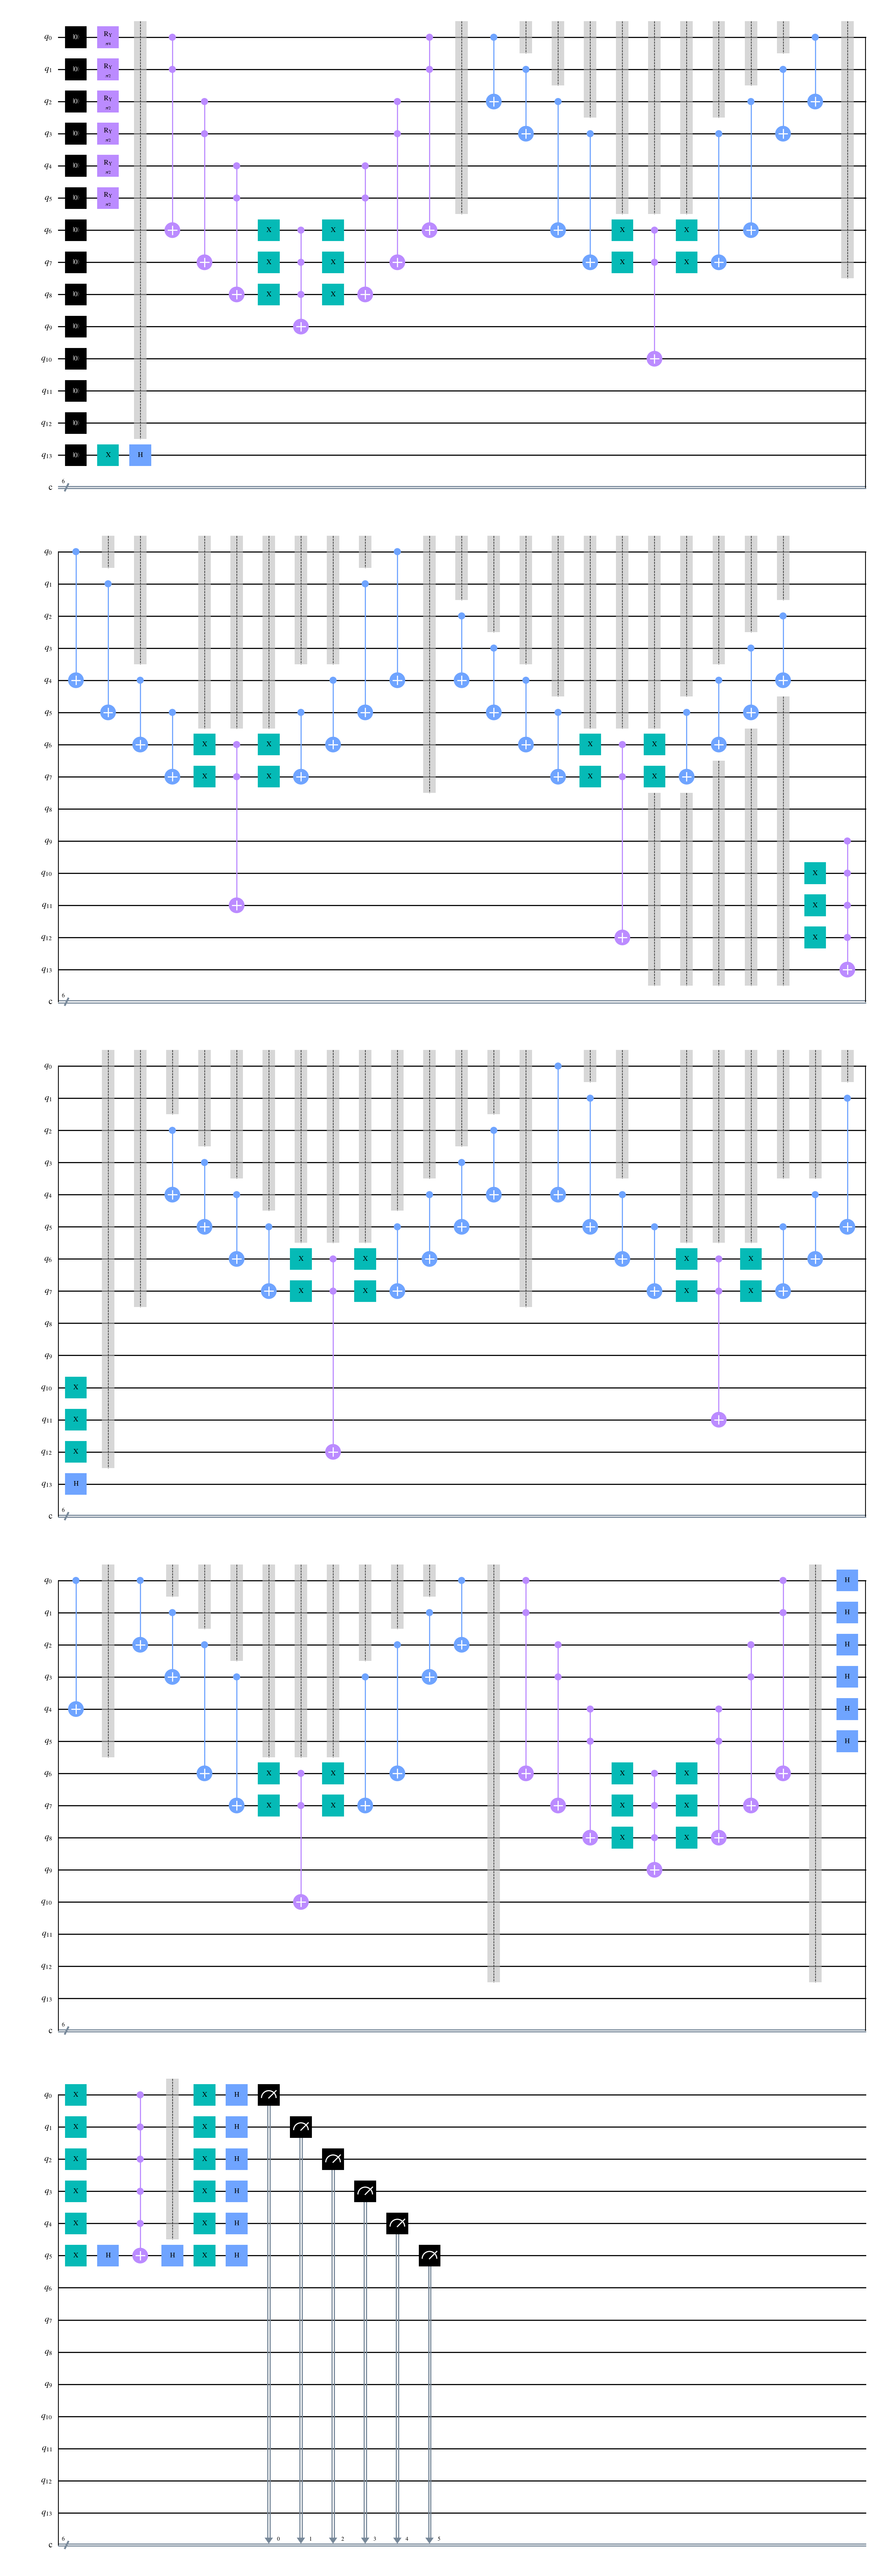

In [64]:
n_qubit = 14
n_matching = 6
grover_circuit = QuantumCircuit(n_qubit, n_matching)
grover_circuit.reset(range(0, 14))
grover_circuit = initialize_s(grover_circuit, n_qubit, n_matching)
for i in range(1):
    grover_circuit = violate_state(grover_circuit)
    grover_circuit = compare_node1_node2(grover_circuit)
    grover_circuit = compare_node1_node3(grover_circuit)
    grover_circuit = compare_node2_node3(grover_circuit)
    grover_circuit.barrier([8, 9, 10, 11, 12, 13])
    grover_circuit.barrier([8, 9, 10, 11, 12, 13])
    grover_circuit.barrier([7, 8, 9, 10, 11, 12, 13])
    grover_circuit.barrier([6, 7, 8, 9, 10, 11, 12, 13])
    grover_circuit.barrier([5, 6, 7, 8, 9, 10, 11, 12, 13])
    #grover_circuit.barrier([7, 8, 9, 10, 11, 12, 13, 14, 15])
    #grover_circuit.barrier([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
    grover_circuit.x([10, 11, 12])
    grover_circuit.mcx([9, 10, 11, 12], 13)
    grover_circuit.x([10, 11, 12])
    grover_circuit.h([13])
    grover_circuit.barrier([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    grover_circuit = compare_node2_node3(grover_circuit)
    grover_circuit = compare_node1_node3(grover_circuit)
    grover_circuit = compare_node1_node2(grover_circuit)
    grover_circuit = violate_state(grover_circuit)
    grover_circuit.barrier([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    grover_circuit = diffuser_2(grover_circuit, 6)
# for i in range(1):
#     #grover_circuit = violate_state(grover_circuit)
#     grover_circuit.append(violate_state(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
#     grover_circuit.append(compare_node1_node2(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
#     grover_circuit.append(compare_node1_node3(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
#     grover_circuit.append(compare_node2_node3(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
#     grover_circuit.x([10, 11, 12])
#     grover_circuit.mcx([9, 10, 11, 12], 13)
#     grover_circuit.x([10, 11, 12])
#     grover_circuit.h([13])
#     grover_circuit.append(compare_node2_node3(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
#     grover_circuit.append(compare_node1_node3(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
#     grover_circuit.append(compare_node1_node2(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
#     grover_circuit.append(violate_state(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
#     grover_circuit.append(diffuser(6), [0, 1, 2, 3, 4, 5])
    
grover_circuit.measure([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5])
grover_circuit.draw(output = "mpl")

In [65]:
from qiskit import BasicAer, Aer,execute
sim = Aer.get_backend('aer_simulator')

In [66]:
job = execute(grover_circuit, backend = sim, shots = 8192)

In [67]:
counts = job.result().get_counts()

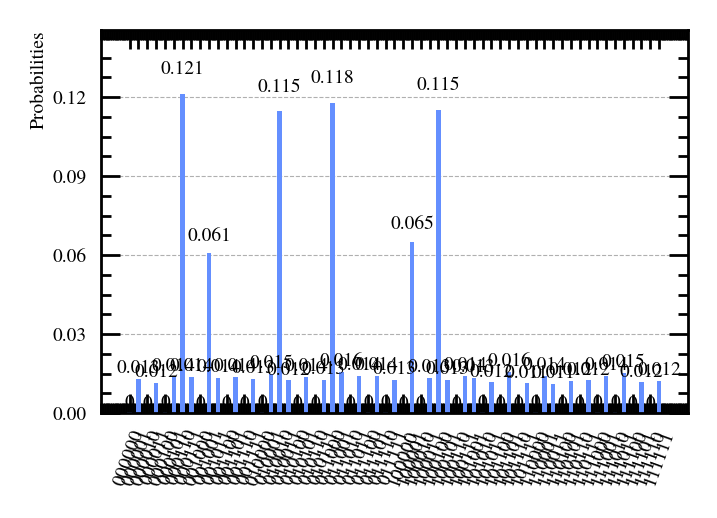

In [69]:
plot_histogram(counts)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

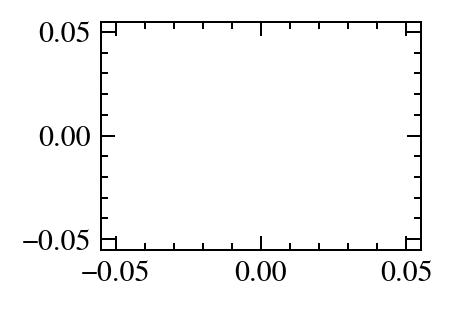

In [13]:
#이미지의 이름을 label= '(이름)'으로 사용. Latex식 수식 지원.
plt.plot([], [], ' ', label='$Matching Simulated QSA')

#np.histrogram(히스토그램을 그릴 데이터, bin 사이즈)
#np.linspace(시작지점, 끝지점, n등분)
h, bins = np.histogram(counts)
#h, bins는 고정, label은 plot의 이름
mplhep.histplot(h, bins)

#x,y축 이름 지정
plt.xlabel('Momentum [MeV]')
plt.ylabel('Events')

#y축 log scale. 비활성화는 밑줄을 지우면 됨
plt.yscale('log')

#x축 범위. y축도 동일하게 plt.ylim으로 지정가능
plt.xlim(0,10)
plt.legend()

#이미지를 경로에 저장. 확장자는 .pdf, .png, .jpeg등 가능
#plt.savefig('/home/seokju/Documents/KNU/Plots/220530/Sr_DisplacementCut.pdf')

#이미지 저장을 비활성화할시 plt.show()를 사용해야함
plt.show()

In [70]:
IBMQ.save_account('e98108019189dbd357958aedc14339c82ad0b0e12ec45536f7b7604eb16e2ff549e5041663ac8cffac7a0e0a8843588f4b839d6bad9851ca44c04aa29b273ba0', overwrite=True)

In [71]:
provider = IBMQ.load_account()

In [72]:
provider = IBMQ.get_provider(hub='ibm-q-skku', group='korea-university', project='ku-students')

#backends = provider.backends()

In [73]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-skku', group='korea-university', project='ku-students')>,
 <IBMQBackend('ibmq_montreal') from IBMQ(hub='ibm-q-skku', group='korea-university', project='ku-students')>,
 <IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-skku', group='korea-university', project='ku-students')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-skku', group='korea-university', project='ku-students')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-skku', group='korea-university', project='ku-students')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-skku', group='korea-university', project='ku-students')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-skku', group='korea-university', project='ku-students')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-skku', group='korea-university', project='ku-students')>,
 <IBMQBackend('ibmq_guadalupe') from IBMQ(hub='ibm-q-skku', group='korea-university', project='ku-students')>,
 <IBMQSimulator

In [74]:
device = provider.backends()[0]

In [75]:
device

<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-skku', group='korea-university', project='ku-students')>

In [76]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=1)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


In [77]:
# Get the results from the computation
results = job.result()


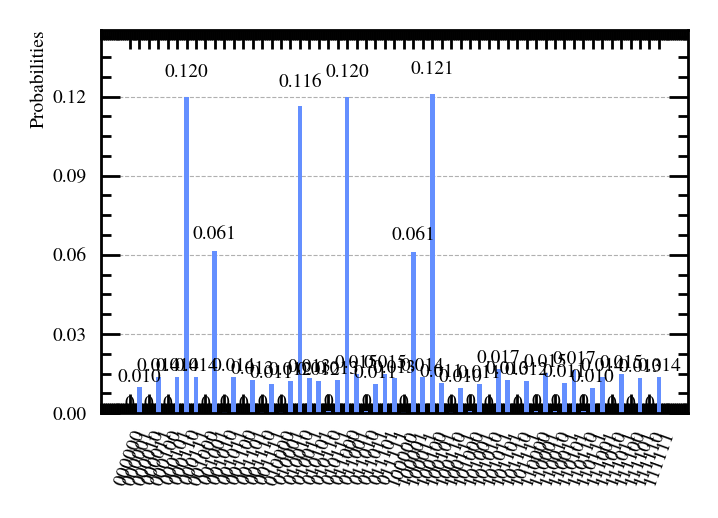

In [78]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

In [79]:

answer = results.get_counts(grover_circuit)


In [80]:
answer

{'000000': 1,
 '000001': 40,
 '010000': 2,
 '010001': 49,
 '010010': 465,
 '010011': 54,
 '010101': 49,
 '010110': 3,
 '010111': 51,
 '011000': 479,
 '011001': 60,
 '011010': 3,
 '011011': 45,
 '011101': 60,
 '011111': 53,
 '000010': 1,
 '100000': 2,
 '100001': 244,
 '100011': 55,
 '100100': 484,
 '100101': 46,
 '100110': 2,
 '100111': 39,
 '101000': 3,
 '101001': 45,
 '101010': 1,
 '101011': 67,
 '101101': 51,
 '101110': 1,
 '101111': 49,
 '000011': 55,
 '110000': 3,
 '110001': 61,
 '110010': 3,
 '110011': 46,
 '110101': 66,
 '110110': 3,
 '110111': 39,
 '111001': 55,
 '111010': 1,
 '111011': 60,
 '111100': 1,
 '111101': 54,
 '111110': 1,
 '111111': 55,
 '000100': 1,
 '000101': 55,
 '000110': 479,
 '000111': 55,
 '001000': 1,
 '001001': 246,
 '001010': 2,
 '001011': 55,
 '001100': 1,
 '001101': 51,
 '001110': 2,
 '001111': 45}